## **Ejercicio 1**

In [ ]:
pip install pandas-profiling==2.8.0   # Para reproducibilidad del Pandas Report

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from pandas_profiling import ProfileReport

%matplotlib inline

In [2]:
df = pd.read_csv('./docs/data.csv')
df.head()

,date,channelGrouping,userAgeBracket,userType,sessions,transactions
0,20190101,(Other),25-34,New Visitor,17,0
1,20190101,(Other),25-34,Returning Visitor,30,2
2,20190101,(Other),35-44,New Visitor,11,0
3,20190101,(Other),35-44,Returning Visitor,71,2
4,20190101,(Other),45-54,Returning Visitor,11,0


Una buena manera de hacernos una idea de la estructura del dataset y de los posibles problemas (missing y extreme values, ceros, sampling bias) es usar el Pandas Profile Report. Clicar [aquí](https://rcruzgar.github.io/conversion_rate/) para abrirlo directamente.

Todo parece correcto.




In [ ]:
profile = ProfileReport(df, minimal=True)
profile.to_file("index.html")

Formateamos las fechas para que no haya problemas posteriormente:

In [3]:
df['date'] = pd.to_datetime(df['date'], format='%Y%m%d')

In [4]:
df['date'].unique()

array(['2019-01-01T00:00:00.000000000', '2019-01-02T00:00:00.000000000',
       '2019-01-03T00:00:00.000000000', '2019-01-04T00:00:00.000000000',
       '2019-01-05T00:00:00.000000000', '2019-01-06T00:00:00.000000000',
       '2019-01-07T00:00:00.000000000', '2019-01-08T00:00:00.000000000',
       '2019-01-09T00:00:00.000000000', '2019-01-10T00:00:00.000000000',
       '2019-01-11T00:00:00.000000000', '2019-01-12T00:00:00.000000000',
       '2019-01-13T00:00:00.000000000', '2019-01-14T00:00:00.000000000',
       '2019-01-15T00:00:00.000000000', '2019-01-16T00:00:00.000000000',
       '2019-01-17T00:00:00.000000000', '2019-01-18T00:00:00.000000000',
       '2019-01-19T00:00:00.000000000', '2019-01-20T00:00:00.000000000',
       '2019-01-21T00:00:00.000000000', '2019-01-22T00:00:00.000000000',
       '2019-01-23T00:00:00.000000000', '2019-01-24T00:00:00.000000000',
       '2019-01-25T00:00:00.000000000', '2019-01-26T00:00:00.000000000',
       '2019-01-27T00:00:00.000000000', '2019-01-28

**Primer día**: 1 de enero de 2019.
**Último día**: 27 de octubre de 2019.

> Total: 300 días

Creamos dos columnas que nos pueden ser útiles: Month (1 a 10 --> Enero a Octubre) y Weekday (1 a 7 --> Lunes a Domingo).

In [5]:
df['month'] = df['date'].dt.month
df['weekday'] = df['date'].dt.weekday

In [6]:
df['channelGrouping'].unique()

array(['(Other)', 'Direct - Non Paid',
       'Email - Newsletter Franquicias - Non Paid',
       'Email - Newsletter Offline - Non Paid',
       'Email - Newsletter Online - Non Paid',
       'Email - Newsletter Outlet - Non Paid', 'Email - Other - Non Paid',
       'Email - Triggered - Non Paid', 'Referral - Affiliates - Paid',
       'Referral - Other - Non Paid', 'Search - Branded - Paid',
       'Search - SEO - Non Paid', 'Search - Shopping - Paid',
       'Social - Brand - Paid', 'Social - DPA - Paid',
       'Social - Organic - Non Paid', 'Social - Performance - Paid',
       'Search - Generic - Paid', 'Referral - Press - Paid',
       'Referral - Influencers - Paid', 'Email - SMS - Non Paid'],
      dtype=object)

Simplificamos los tipos de canal, agregando según la primera palabra de la descripción (Other, Email, Referral, Search, Direct, Social).

In [7]:
chanel_list = ['Other', 'Email', 'Referral', 'Search', 'Direct', 'Social']
for chanel in chanel_list:
  df.loc[df['channelGrouping'].str.contains(chanel), 'channelGrouping'] = chanel

In [8]:
df['channelGrouping'].unique()

array(['Other', 'Direct', 'Email', 'Referral', 'Search', 'Social'],
      dtype=object)

Convertimos los rangos de edad, el tipo de usuario y el canal a índices numéricos para facilitar la exploración. Para ello generamos 3 nuevas columnas:


In [9]:
df['user'] = df['userType'].apply(lambda row: 0 if row == "New Visitor" else 1)

In [10]:
df['age_range'] = df['userAgeBracket'].replace(to_replace=['18-24', '25-34', '35-44', '45-54', '55-64', '65+'], value=[0,1,2,3,4,5])

In [11]:
df['channel'] = df['channelGrouping'].replace(to_replace=['Other', 'Email', 'Referral', 'Search', 'Direct', 'Social'], value=[0,1,2,3,4,5])

In [12]:
df.tail()

,date,channelGrouping,userAgeBracket,userType,sessions,transactions,month,weekday,user,age_range,channel
48847,2019-10-27,Social,45-54,Returning Visitor,481,2,10,6,1,3,5
48848,2019-10-27,Social,55-64,New Visitor,192,1,10,6,0,4,5
48849,2019-10-27,Social,55-64,Returning Visitor,303,0,10,6,1,4,5
48850,2019-10-27,Social,65+,New Visitor,111,0,10,6,0,5,5
48851,2019-10-27,Social,65+,Returning Visitor,161,2,10,6,1,5,5


Calculamos el *Conversion Rate* (%):

In [13]:
df['conversion'] = (df['transactions']/df['sessions'])*100

Correlaciones entre variables. Aparte de que las sesiones y las transacciones están correlacionadas, podríamos destacar la correlación del tipo de usuario.

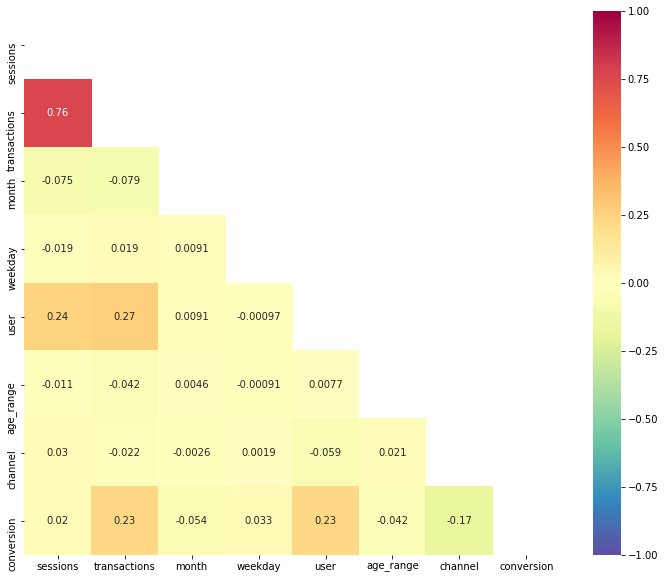

In [14]:
plt.figure(figsize=(12,10))
matrix = np.triu(df.corr())
sns.heatmap(df.corr(),cmap='Spectral_r',mask=matrix,annot=True,cbar=True,vmin=-1,vmax=1,center=0)

Scatter plot de las sesiones vs las transacciones. Generalmente para conseguir de 10-20 transacciones, se tienen que dar unas 500-1500 sesiones.

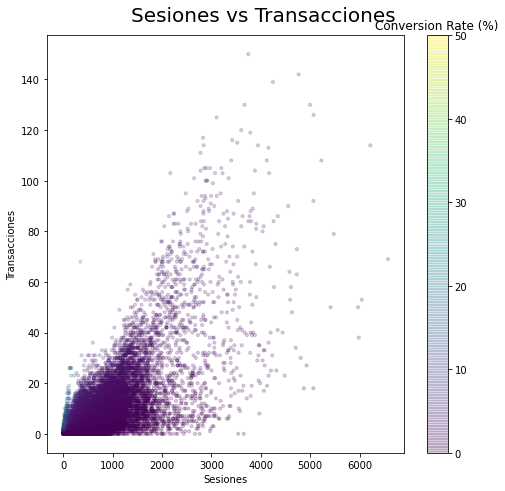

In [17]:
fig1 = plt.figure(figsize=(8,8))
ax = fig1.add_subplot(1, 1, 1)
sc = plt.scatter(df['sessions'], df['transactions'],
                    alpha = 0.2, s = 10, c=df['conversion'])
plt.xlabel('Sesiones')
plt.ylabel('Transacciones')
fig1.suptitle('Sesiones vs Transacciones', size=20, y=0.9)
cbar = plt.colorbar(spacing='proportional')
cbar.ax.set_title('Conversion Rate (%)')
plt.subplots_adjust(top=0.85)
plt.show()

Dibujamos la serie temporal de Conversion Rate (azul) con una media móvil de 10 días (naranja). Es interesante ver la estacionalidad del Conversion Rate, con una tendencia al alza a principios de año y verano.

In [18]:
daily_conversion = df.groupby('date')[['conversion']].mean()
rolling_mean = daily_conversion.rolling(window=10).mean()

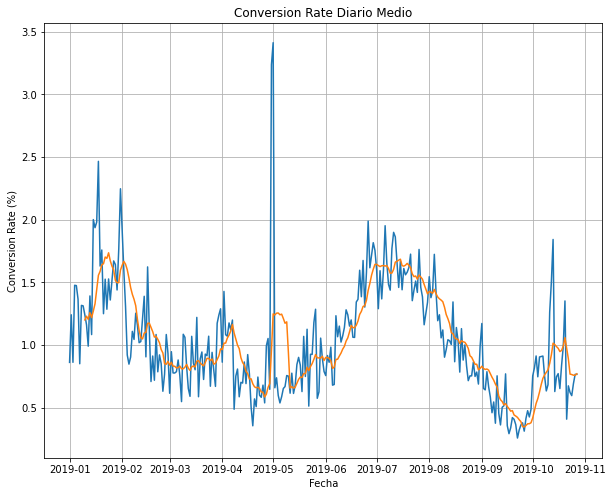

In [19]:
plt.figure(figsize=(10,8))
plt.plot(daily_conversion.index, daily_conversion)
plt.plot(rolling_mean)
plt.title('Conversion Rate Diario Medio')
plt.xlabel('Fecha')
plt.ylabel('Conversion Rate (%)')
plt.grid(True)
plt.show()

El día con el mayor Conversion Rate de media corresponde al 1 de mayo (Festivo por el Día del Trabajador):

In [20]:
daily_conversion.idxmax()

conversion   2019-05-01
dtype: datetime64[ns]

In [22]:
daily_transaction = df.groupby('date')[['transactions']].sum()
daily_session = df.groupby('date')[['sessions']].sum()

Comparando el total de transacciones y sesiones diarias podemos ver que el 1 de mayo hubo una caida drástica en las sesiones, lo que ocasionó un mayor Conversion Rate (ya que las transacciones se mantuvieron).

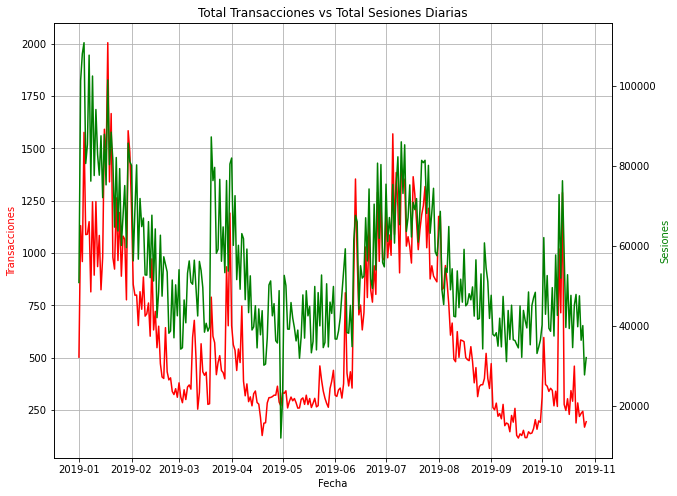

In [23]:
fig, ax1 = plt.subplots(figsize=(10, 8))
ax2 = ax1.twinx()
ax1.plot(daily_transaction.index, daily_transaction, c='r')
ax2.plot(daily_session.index, daily_session, c='g')
plt.title('Total Transacciones vs Total Sesiones Diarias')
ax1.set_xlabel('Fecha')
ax1.set_ylabel('Transacciones', color='r')
ax2.set_ylabel('Sesiones', color='g')
ax1.grid(True)
plt.show()

En las siguientes figuras exploramos en más profundidad la evolución del Conversion Rate medio por canal y tipo de usuario separando los rangos de edad. Hacemos una media móvil de 10 días para suavizar la señal y mejorar la interpretabilidad. Se observa una estacionalidad, sobre todo para los *Returning Visitors*, que es menos ruidoso que el Conversion Rate en los *New Visitors*. Nótese que el eje vertical del Conversion Rate no es el mismo entre los subpaneles. Para los *Returning Visitors*, los jóvenes (18-24 años) son los que mayor Conversion Rate generan en Referral, Search y Social.

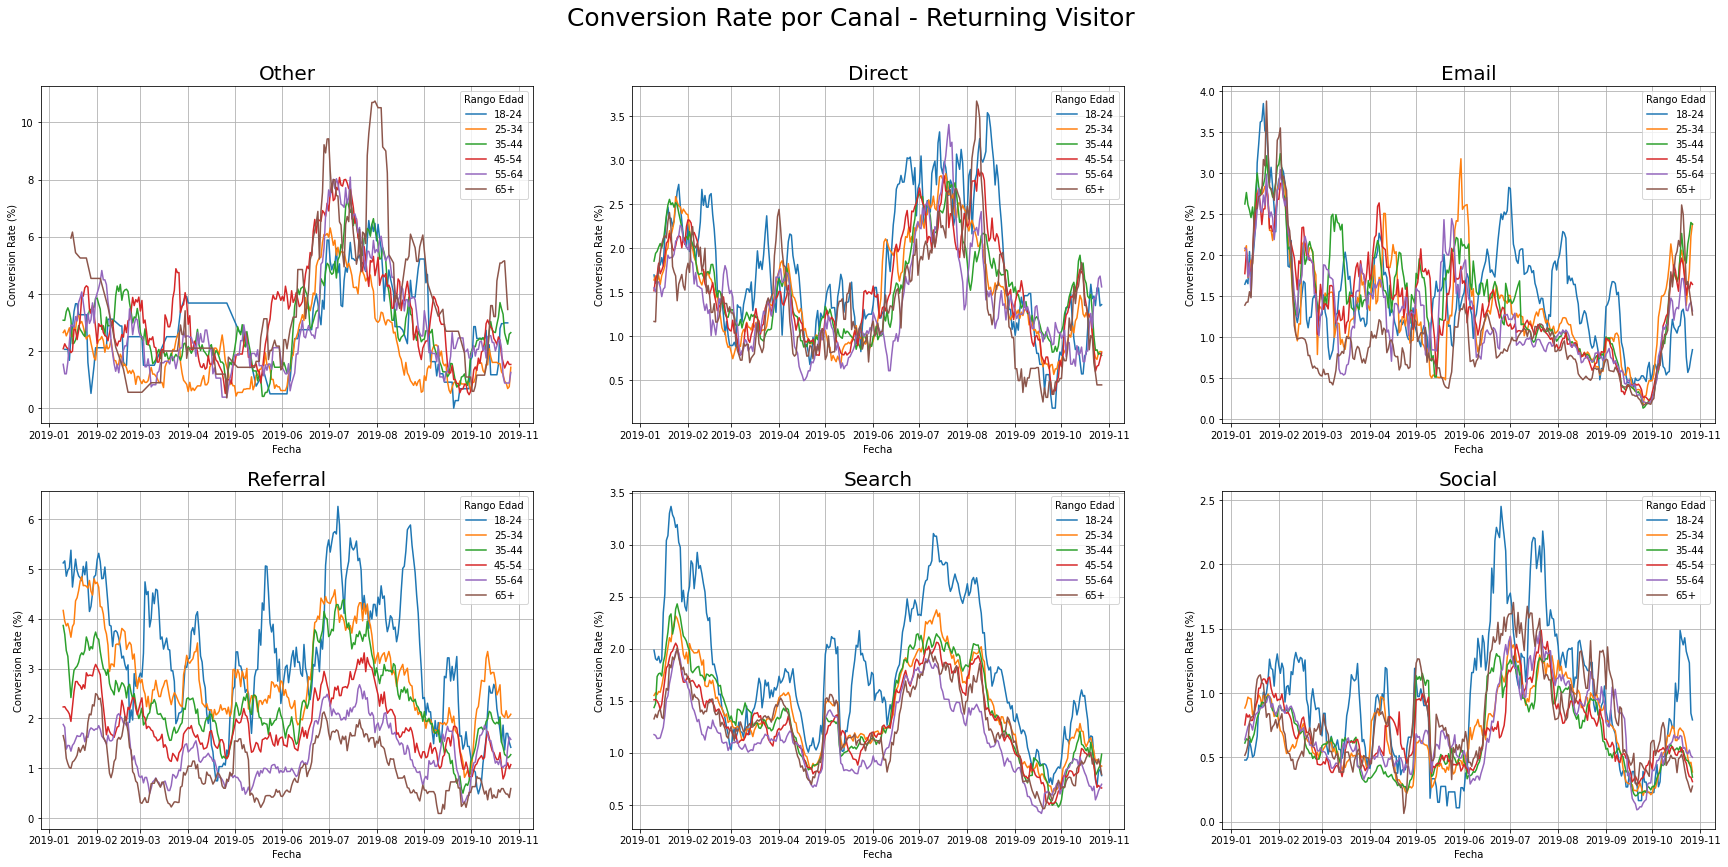

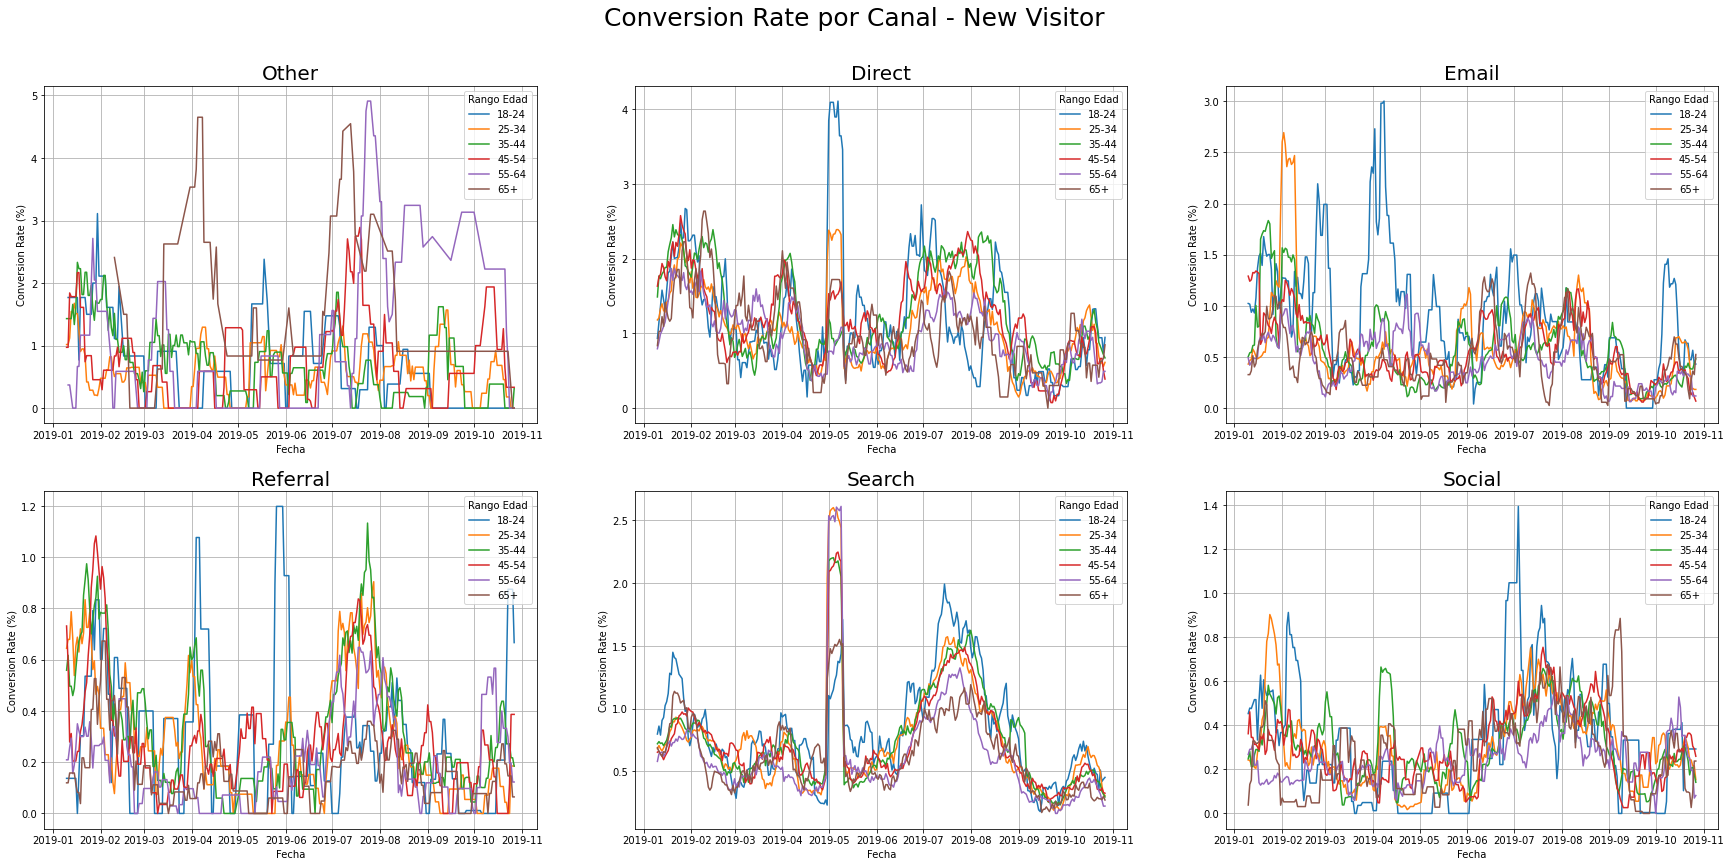

In [24]:
legend_labels = df['userAgeBracket'].unique().tolist()
lst_chanel = df['channelGrouping'].unique().tolist()
lst_age = ['18-24', '25-34', '35-44', '45-54', '55-64', '65+']
lst_user = ['Returning Visitor', 'New Visitor']

for user in lst_user:
  fig = plt.figure(figsize=(30,22))
  index = 0
  for chanel in lst_chanel:
    index += 1
    ax = fig.add_subplot(3, 3, index)
    ax.set_title(chanel, fontsize= 20)
    for age in lst_age:
      subset = df.groupby(['date', 'userType', 'userAgeBracket', 'channelGrouping'])[['conversion']].mean() 
      sele3 = subset.xs((user, chanel, age), level=('userType', 'channelGrouping', 'userAgeBracket'), axis=0)
      mov_window = sele3.rolling(window=10).mean()
      ax.plot(mov_window.index, mov_window, label = age)
      plt.xlabel('Fecha')
      plt.ylabel('Conversion Rate (%)')
      ax.grid(True)
      ax.legend(title="Rango Edad")
  fig.suptitle('Conversion Rate por Canal - {0}'.format(user), size=25, y=0.9)
  plt.subplots_adjust(top=0.85)
  plt.show()

De los siguientes barplots se deduce que:

- Por edad, los más jóvenes (18-24) son los que más Conversion Rate generan, mientras que los mayores de 65, los que menos.

- Los lunes el Conversion Rate es más bajo que el resto de días, siendo el domingo cuando más Conversion Rate hay.

- Como hay bastante variabilidad en el Conversion Rate dependiendo del canal, nos centraremos en los canales y la edad.

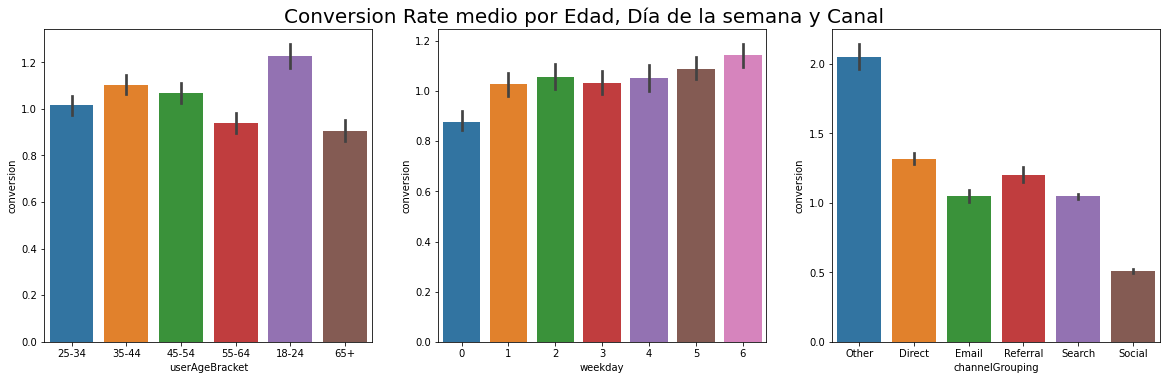

In [25]:
columns_for_barplot = ['userAgeBracket', 'weekday', 'channelGrouping']
                
fig1 = plt.figure(figsize=(20,6))
index = 0
for var in columns_for_barplot:
    index += 1
    ax = fig1.add_subplot(1, 3, index)
    sns.barplot(x=var, y='conversion', data=df)
    plt.subplots_adjust(top=0.85)
fig1.suptitle('Conversion Rate medio por Edad, Día de la semana y Canal', size=20, y=0.9)
plt.show()

El mismo plot dividiendo por *User Type*:

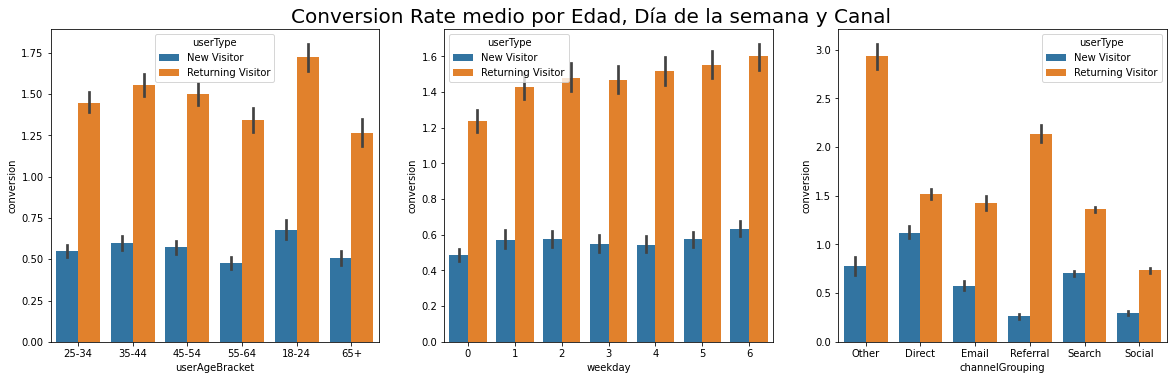

In [26]:
columns_for_barplot = ['userAgeBracket', 'weekday', 'channelGrouping']
                
fig1 = plt.figure(figsize=(20,6))
index = 0
for var in columns_for_barplot:
    index += 1
    ax = fig1.add_subplot(1, 3, index)
    sns.barplot(x=var, y='conversion', data=df, hue = 'userType')
    plt.subplots_adjust(top=0.85)
fig1.suptitle('Conversion Rate medio por Edad, Día de la semana y Canal', size=20, y=0.9)
plt.show()

*Izquierda*: Violin plot de la distribución de Conversion Rate por día de la semana y usuario. Hay muchos outliers. El *returning visitor* generando de media más Conversion Rate, como puede verse a la *derecha* (más del doble).

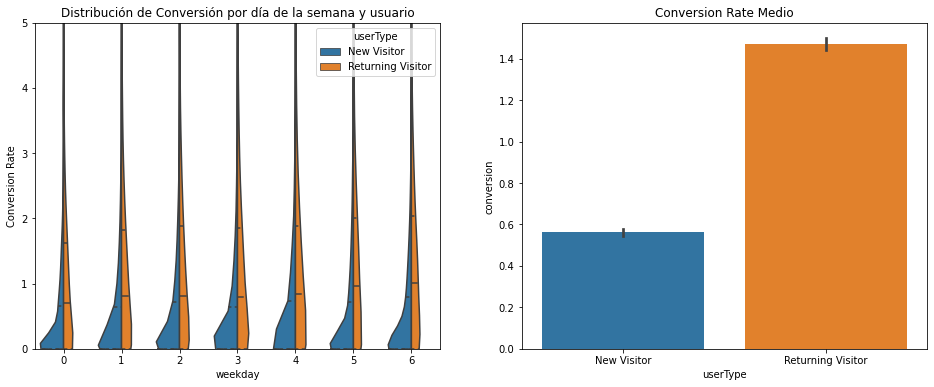

In [27]:
plt.figure(figsize=(16,6))
plt.subplot(1, 2, 1)
sns.violinplot(x='weekday', y='conversion', hue='userType',data=df,
                 split=True,inner='quartile')
plt.ylim(0,5)
plt.title("Distribución de Conversión por día de la semana y usuario")
plt.ylabel("Conversion Rate")
plt.subplot(1, 2, 2)
sns.barplot(x='userType', y='conversion', data=df)
plt.title('Conversion Rate Medio')
plt.show()

Creamos una columna con un 0 cuando no hay conversión, y un 1 cuando sí la hay:

In [28]:
df['converted'] = df['conversion'].apply(lambda row: 0 if row == 0 else 1)

In [29]:
sessions_conv = df.groupby('sessions')[['converted']].mean()

Hay un crecimiento exponencial en la probabilidad de Conversion Rate conforme se aumenta el número de sesiones. A partir de las ~1000 sesiones, esta relación no es tan clara. También cabe destacar que para algunos casos con muy pocas sesiones, la probabilidad de conversión es muy alta.

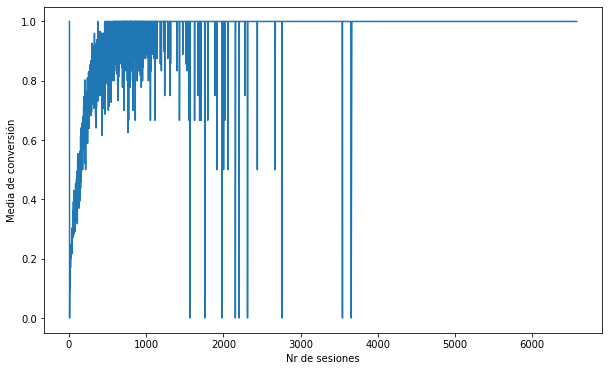

In [30]:
plt.figure(figsize=(10,6))
plt.plot(sessions_conv.index, sessions_conv['converted'])
plt.xlabel('Nr de sesiones')
plt.ylabel('Media de conversión')
plt.show()

Proporción de conversiones sobre el total y de sesiones recurrentes sobre sesiones convertidas:

In [31]:
users_converted = df['converted'][df['converted']==1].sum()
prop = (users_converted/df.shape[0])

users_converted_ret = df['converted'][(df['converted']==1) & (df['userType']=='Returning Visitor')].sum()
prop_ret = (users_converted_ret/users_converted)

print("La proporción de usuarios convertidos es {0:.2%}".format(prop))
print("La proporción de usuarios recurrentes sobre todos los convertidos es {0:.2%}".format(prop_ret))

La proporción de usuarios convertidos es 55.75%
La proporción de usuarios recurrentes sobre todos los convertidos es 66.24%


Ahora analizaremos el Conversion Rate por edad y canal para los dos tipos de visitantes por separado.

### Returning Visitor:

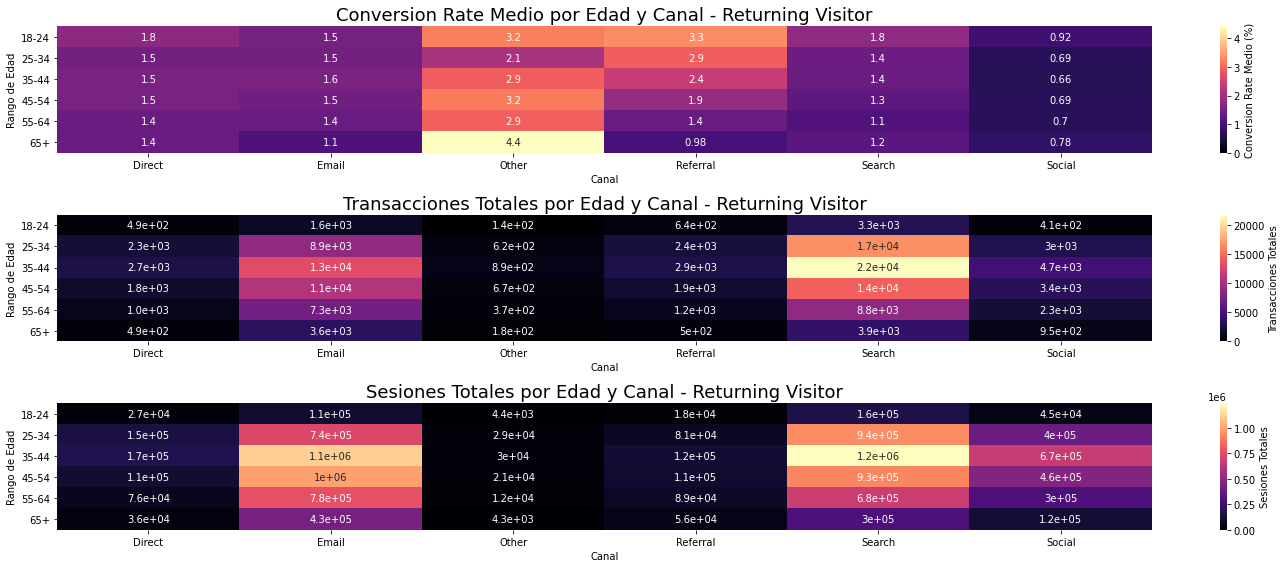

In [32]:
plt.figure(figsize=(20,8))
ax1 = plt.subplot(3,1,1)
sns.heatmap(data=pd.crosstab(df.userAgeBracket, df.channelGrouping, values=df.conversion[df['userType']=='Returning Visitor'], aggfunc='mean'),
            vmin=0, cmap='magma', annot=True, cbar_kws={'label': 'Conversion Rate Medio (%)'})
plt.ylabel('Rango de Edad')
plt.xlabel('Canal')
plt.title('Conversion Rate Medio por Edad y Canal - Returning Visitor', fontsize = 18)

ax2 = plt.subplot(3,1,2)
sns.heatmap(data=pd.crosstab(df.userAgeBracket, df.channelGrouping, values=df.transactions[df['userType']=='Returning Visitor'], aggfunc='sum'),
            vmin=0, cmap='magma', annot=True, cbar_kws={'label': 'Transacciones Totales'})
plt.ylabel('Rango de Edad')
plt.xlabel('Canal')
plt.title('Transacciones Totales por Edad y Canal - Returning Visitor', fontsize = 18)

ax3 = plt.subplot(3,1,3)
sns.heatmap(data=pd.crosstab(df.userAgeBracket, df.channelGrouping, values=df.sessions[df['userType']=='Returning Visitor'], aggfunc='sum'),
            vmin=0, cmap='magma', annot=True, cbar_kws={'label': 'Sesiones Totales'})
plt.ylabel('Rango de Edad')
plt.xlabel('Canal')
plt.title('Sesiones Totales por Edad y Canal - Returning Visitor', fontsize = 18)

plt.tight_layout()
plt.show()

### New Visitor:

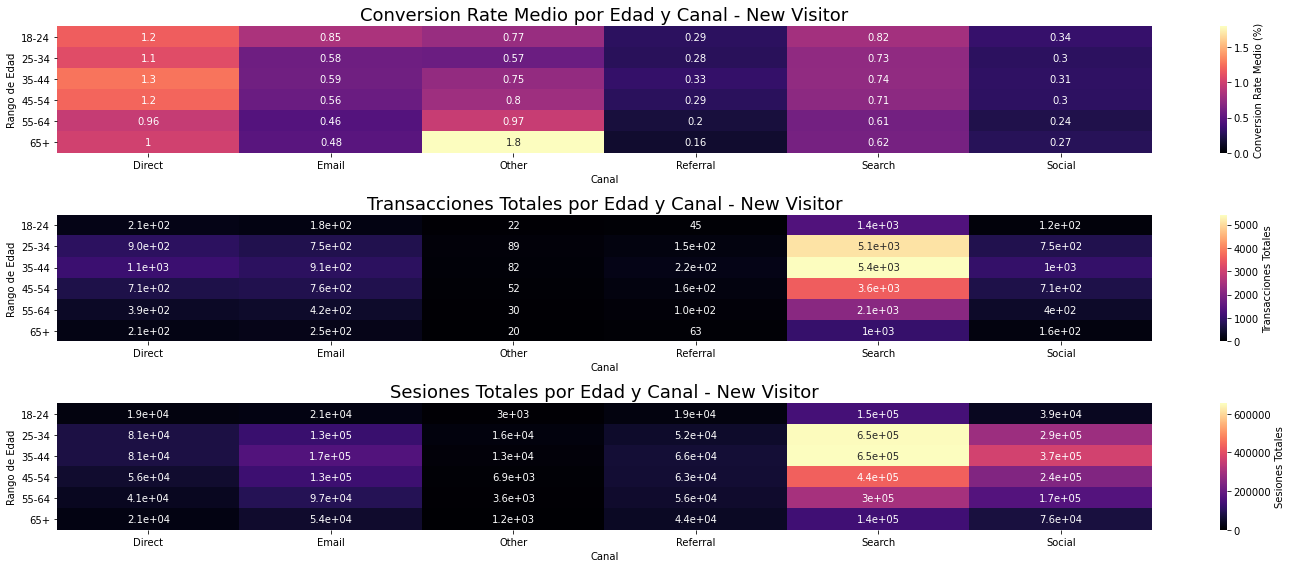

In [33]:
plt.figure(figsize=(20,8))
ax1 = plt.subplot(3,1,1)
sns.heatmap(data=pd.crosstab(df.userAgeBracket, df.channelGrouping, values=df.conversion[df['userType']=='New Visitor'], aggfunc='mean'),
            vmin=0, cmap='magma', annot=True, cbar_kws={'label': 'Conversion Rate Medio (%)'})
plt.ylabel('Rango de Edad')
plt.xlabel('Canal')
plt.title('Conversion Rate Medio por Edad y Canal - New Visitor', fontsize = 18)

ax2 = plt.subplot(3,1,2)
sns.heatmap(data=pd.crosstab(df.userAgeBracket, df.channelGrouping, values=df.transactions[df['userType']=='New Visitor'], aggfunc='sum'),
            vmin=0, cmap='magma', annot=True, cbar_kws={'label': 'Transacciones Totales'})
plt.ylabel('Rango de Edad')
plt.xlabel('Canal')
plt.title('Transacciones Totales por Edad y Canal - New Visitor', fontsize = 18)

ax3 = plt.subplot(3,1,3)
sns.heatmap(data=pd.crosstab(df.userAgeBracket, df.channelGrouping, values=df.sessions[df['userType']=='New Visitor'], aggfunc='sum'),
            vmin=0, cmap='magma', annot=True, cbar_kws={'label': 'Sesiones Totales'})
plt.ylabel('Rango de Edad')
plt.xlabel('Canal')
plt.title('Sesiones Totales por Edad y Canal - New Visitor', fontsize = 18)

plt.tight_layout()
plt.show()

Si tuviésemos que elegir invertir todas las sesiones en el canal con mayor Conversion Rate medio para cada rango de edad por separado (dejando el resto de canales vacíos de sesiones), podríamos aumentar el Conversion Rate medio por rango de edad. Por ejemplo, enfocando todas las sesiones de los usuarios de 18-24 años a *Referral*, el Conversion Rate medio crecería un **1.25%** para ese mismo rango de edad. En la última columna de la siguiente tabla se muestran estas mejoras potenciales para el grupo de visitantes recurrentes y cada rango de edad.

In [34]:
tabla_conversion = pd.crosstab(df.userAgeBracket, df.channelGrouping, values=df.conversion[df['userType']=='Returning Visitor'], aggfunc='mean')
tabla_conversion['mean'] = tabla_conversion.mean(axis=1)
tabla_conversion['max_channel'] = tabla_conversion.idxmax(axis = 1) 
tabla_conversion['max'] = tabla_conversion.max(axis=1)
tabla_conversion.loc['mean'] = tabla_conversion.mean(axis=0)
tabla_conversion.loc['max'] = tabla_conversion.max(axis=0)
tabla_conversion['diff_conversion (%)'] = tabla_conversion['max'] - tabla_conversion["mean"]
tabla_conversion

channelGrouping,Direct,Email,Other,Referral,Search,Social,mean,max_channel,max,diff_conversion (%)
userAgeBracket,,,,,,,,,,
18-24,1.766014,1.505432,3.227202,3.343523,1.781895,0.923164,2.091205,Referral,3.343523,1.252318
25-34,1.487053,1.483619,2.077629,2.907424,1.412373,0.691841,1.676656,Referral,2.907424,1.230767
35-44,1.537206,1.595022,2.893114,2.383210,1.386611,0.661547,1.742785,Other,2.893114,1.150329
45-54,1.536710,1.455389,3.184703,1.851244,1.272547,0.692525,1.665520,Other,3.184703,1.519183
55-64,1.386953,1.370092,2.926694,1.365875,1.109514,0.700719,1.476641,Other,2.926694,1.450053
65+,1.370360,1.087151,4.405535,0.981808,1.238389,0.778366,1.643601,Other,4.405535,2.761933
mean,1.514049,1.416118,3.119146,2.138847,1.366888,0.741360,1.716068,NaN,3.276832,1.560764
max,1.766014,1.595022,4.405535,3.343523,1.781895,0.923164,2.091205,NaN,4.405535,2.314330


Para los *New Visitors* también sería positivo, pero no tan alto:

In [35]:
tabla_conversion2 = pd.crosstab(df.userAgeBracket, df.channelGrouping, values=df.conversion[df['userType']=='New Visitor'], aggfunc='mean')
tabla_conversion2['mean'] = tabla_conversion2.mean(axis=1)
tabla_conversion2['max_channel'] = tabla_conversion2.idxmax(axis = 1) 
tabla_conversion2['max_value'] = tabla_conversion2.max(axis=1)
tabla_conversion2['diff_conversion (%)'] = tabla_conversion2['max_value'] - tabla_conversion2["mean"]
tabla_conversion2

channelGrouping,Direct,Email,Other,Referral,Search,Social,mean,max_channel,max_value,diff_conversion (%)
userAgeBracket,,,,,,,,,,
18-24,1.180521,0.849766,0.766638,0.294102,0.815719,0.336868,0.707269,Direct,1.180521,0.473252
25-34,1.090689,0.583555,0.568135,0.283038,0.731251,0.298395,0.592510,Direct,1.090689,0.498179
35-44,1.270683,0.593618,0.746537,0.334078,0.740025,0.308705,0.665608,Direct,1.270683,0.605076
45-54,1.211721,0.563032,0.797135,0.292244,0.714577,0.303454,0.647027,Direct,1.211721,0.564694
55-64,0.959066,0.462671,0.971265,0.200199,0.605010,0.243490,0.573617,Other,0.971265,0.397648
65+,1.012594,0.483030,1.790456,0.158986,0.618849,0.274046,0.722993,Other,1.790456,1.067462


El Conversion Rate se puede aumentar disminuyendo las sesiones (si mantenemos las transacciones) o aumentando las transacciones (si mantenemos las sesiones). Imaginemos que podemos ahorrarnos 1000 sesiones, estando seguros de que podemos mantener las transacciones. ¿En qué grupo sería más beneficioso?

Restamos 1000 a las sesiones totales por grupo. Calculamos el Conversion Rate del total de los 10 meses. En este caso solo presentamos los visitantes recurrentes porque hemos visto que tiende a ser el grupo que más Conversion Rate genera.

In [36]:
tabla_session1 = pd.crosstab(df.userAgeBracket, df.channelGrouping, values=df.sessions[df['userType']=='Returning Visitor'], aggfunc='sum')
tabla_transaction1 = pd.crosstab(df.userAgeBracket, df.channelGrouping, values=df.transactions[df['userType']=='Returning Visitor'], aggfunc='sum')
tabla_conversion_ene_oct = (tabla_transaction1/tabla_session1)*100

tabla_session1_minus = tabla_session1 - 1000
tabla_session1_minus

channelGrouping,Direct,Email,Other,Referral,Search,Social
userAgeBracket,,,,,,
18-24,25778.0,108200.0,3409.0,17165.0,157390.0,43873.0
25-34,146207.0,740441.0,27516.0,79667.0,941251.0,394473.0
35-44,172451.0,1118504.0,28546.0,116544.0,1241376.0,671197.0
45-54,113957.0,996745.0,19510.0,106023.0,928421.0,463612.0
55-64,74546.0,774543.0,11437.0,88382.0,678798.0,302917.0
65+,34719.0,426589.0,3287.0,55256.0,302841.0,121057.0


Calculamos la diferencia de Conversion Rate que esas 1000 sesiones de menos genera. Vemos que el mayor beneficio se daría para el canal *Other* en todas las edades. Esto es así porque para *Other* el número de sesiones total tiende a ser menor que en otros canales.

In [37]:
tabla_conversion_minus = (tabla_transaction1/tabla_session1_minus)*100

new_table = tabla_conversion_minus - tabla_conversion_ene_oct
new_table["mean"] = new_table.mean(axis=1)
new_table['max_channel'] = new_table.idxmax(axis = 1) 
new_table['max'] = new_table.max(axis=1)
new_table.loc['mean'] = new_table.mean(axis=0)

new_table

channelGrouping,Direct,Email,Other,Referral,Search,Social,mean,max_channel,max
userAgeBracket,,,,,,,,,
18-24,0.070406,0.013423,0.931453,0.204296,0.013193,0.021029,0.208967,Other,0.931453
25-34,0.010635,0.001615,0.079144,0.038061,0.001877,0.001916,0.022208,Other,0.079144
35-44,0.009157,0.001056,0.105167,0.020921,0.001409,0.001039,0.023125,Other,0.105167
45-54,0.013664,0.001073,0.167687,0.016850,0.001674,0.001593,0.033757,Other,0.167687
55-64,0.018645,0.001211,0.258714,0.014646,0.001902,0.002456,0.049596,Other,0.258714
65+,0.039351,0.001984,1.298667,0.016182,0.004207,0.006429,0.227803,Other,1.298667
mean,0.026976,0.003394,0.473472,0.051826,0.004044,0.005744,0.094243,NaN,0.473472


¿Y si aumentaramos las sesiones por 1000 cada día pero no subieran las transacciones? ¿Cuánto afectaría al Conversion Rate y a qué grupos de edad y canales les impactaría más? Es decir, ¿qué grupo es más sensible a sesiones que no consiguen transacción? Vemos con claridad que para visitantes recurrentes, la mayor diferencia respecto a las otras edades sería para 18-24 años, sobre todo *Email* y *Search*.

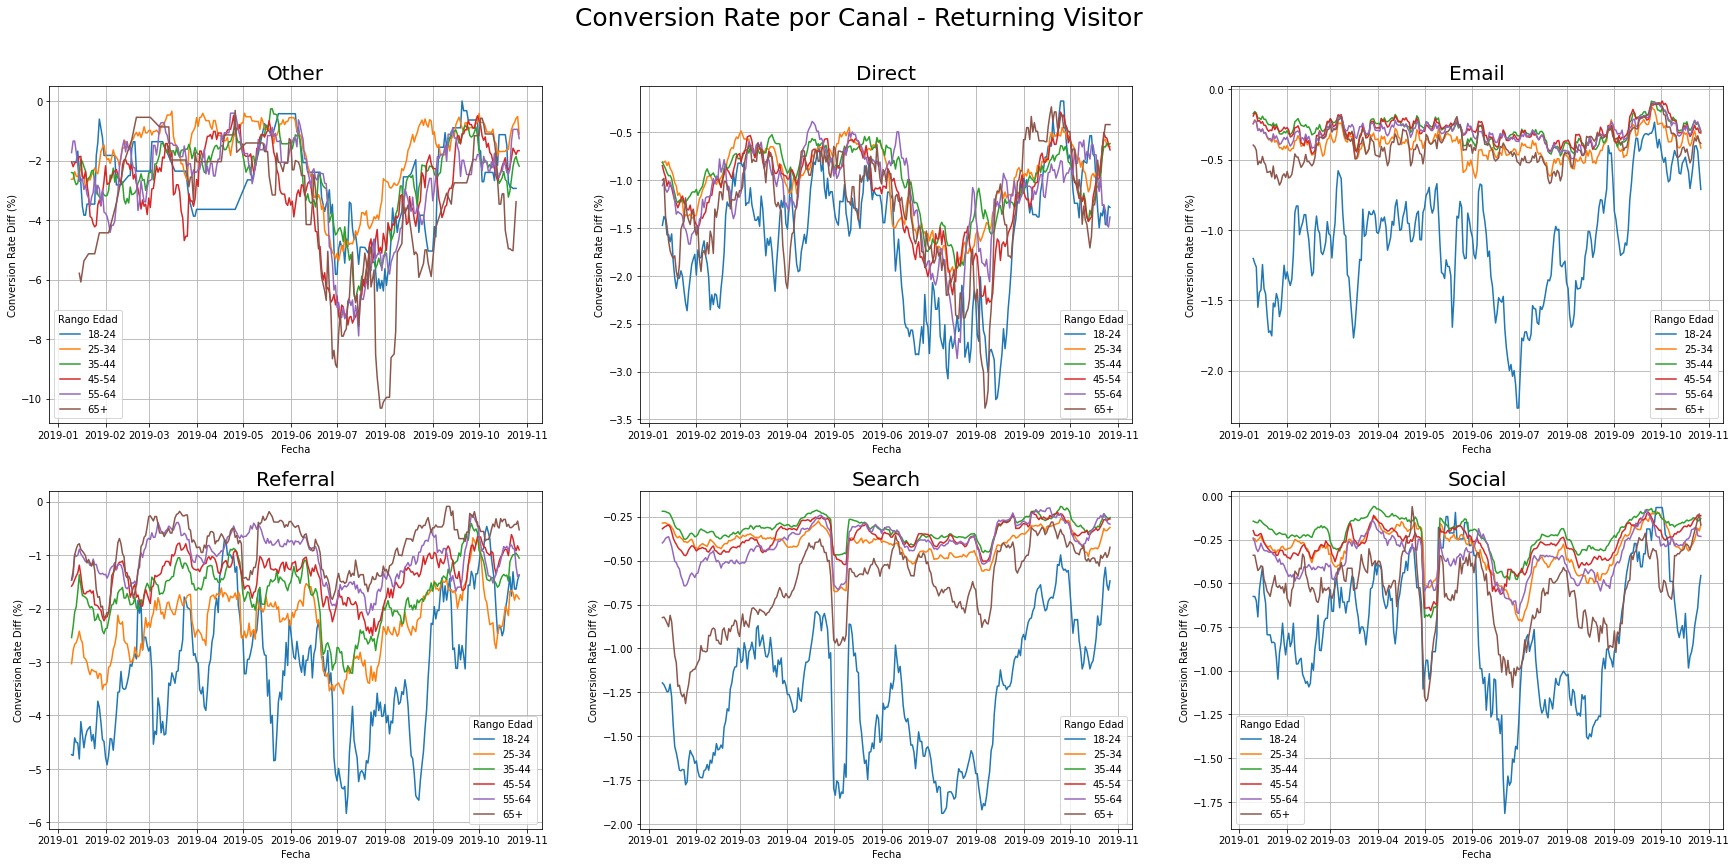

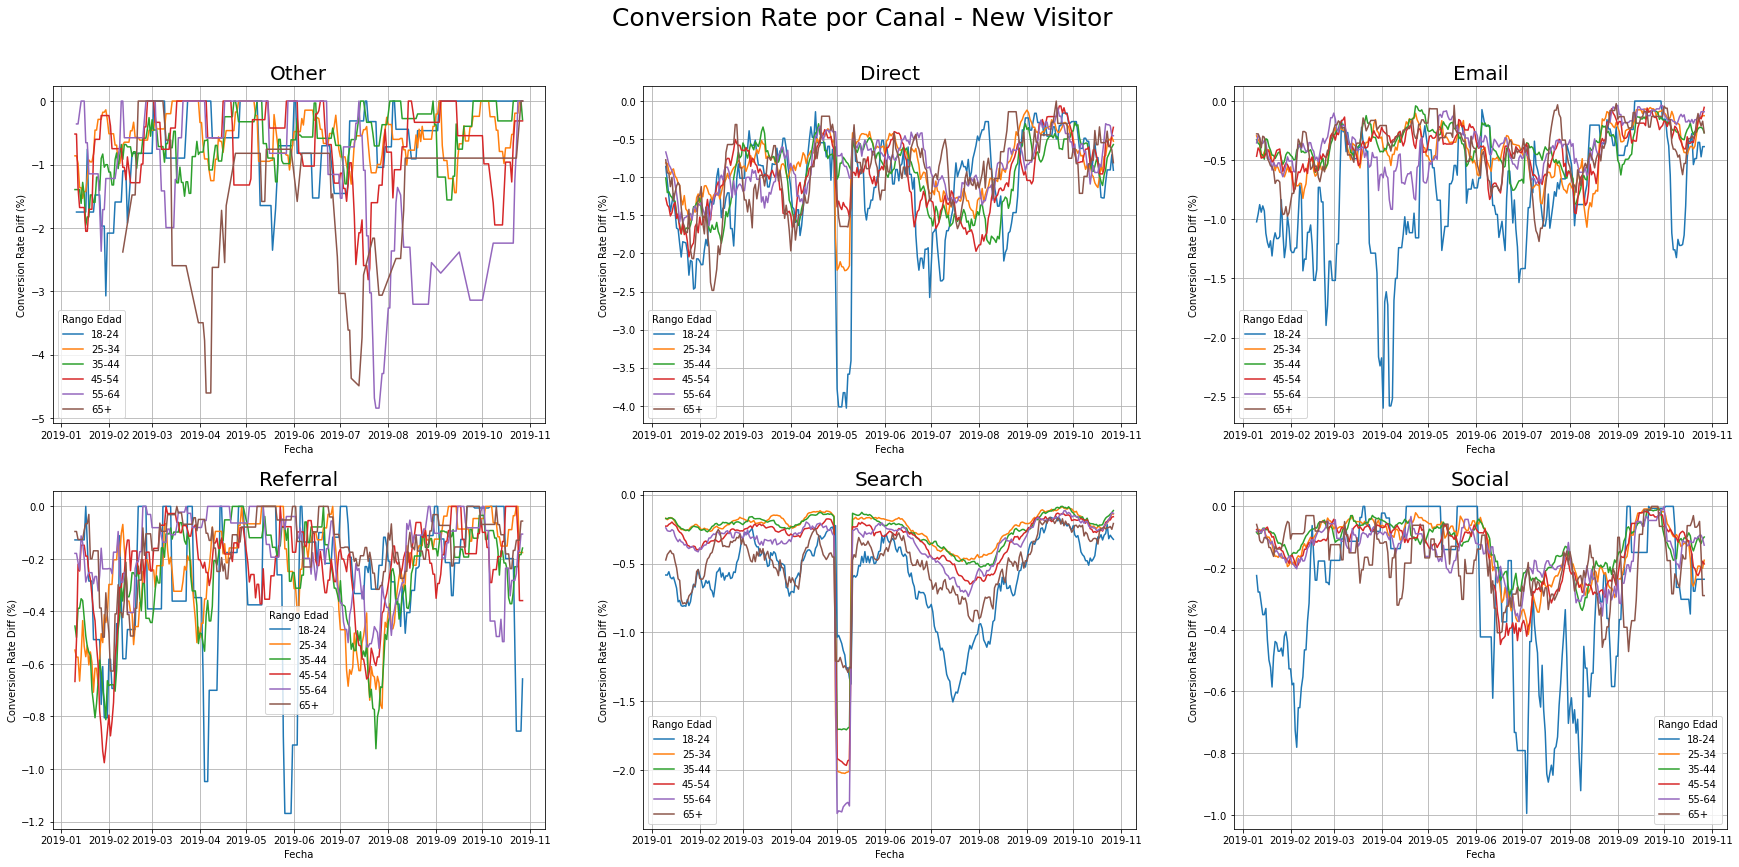

In [38]:
legend_labels = df['userAgeBracket'].unique().tolist()
lst_chanel = df['channelGrouping'].unique().tolist()
lst_age = ['18-24', '25-34', '35-44', '45-54', '55-64', '65+']
lst_user = ['Returning Visitor', 'New Visitor']

for user in lst_user:
  fig = plt.figure(figsize=(30,22))
  index = 0
  for chanel in lst_chanel:
    index += 1
    ax = fig.add_subplot(3, 3, index)
    ax.set_title(chanel, fontsize= 20)
    for age in lst_age:
      subset_sessions = df.groupby(['date', 'userType', 'userAgeBracket', 'channelGrouping'])[['sessions']].sum() 
      subset_transactions = df.groupby(['date', 'userType', 'userAgeBracket', 'channelGrouping'])[['transactions']].sum() 

      sele_transactions = subset_transactions.xs((user, chanel, age), level=('userType', 'channelGrouping', 'userAgeBracket'), axis=0)
      sele_sessions = subset_sessions.xs((user, chanel, age), level=('userType', 'channelGrouping', 'userAgeBracket'), axis=0)
      sele_sessions_plus = sele_sessions + 1000

      conversion_old = (sele_transactions['transactions']/sele_sessions['sessions'])*100
      conversion_new = (sele_transactions['transactions']/sele_sessions_plus['sessions'])*100

      conv_diff = conversion_new - conversion_old

      mov_window = conv_diff.rolling(window=10).mean()
      ax.plot(mov_window.index, mov_window, label = age)
      plt.xlabel('Fecha')
      plt.ylabel('Conversion Rate Diff (%)')
      ax.grid(True)
      ax.legend(title="Rango Edad")
  fig.suptitle('Conversion Rate por Canal - {0}'.format(user), size=25, y=0.9)
  plt.subplots_adjust(top=0.85)
  plt.show()



---

